In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load CSVs (features x samples format, so we need to transpose)
gene_df = pd.read_csv("../NewDatasets/processed_expression_FXS_OG.csv", index_col=0).T
meth_df = pd.read_csv("../NewDatasets/processed_methylation_FXS_OG.csv", index_col=0).T
cnv_df  = pd.read_csv("../NewDatasets/processed_cnv_FXS_OG.csv", index_col=0).T

# apply standard scaling to all data
scaler_meth = StandardScaler()
meth_df = pd.DataFrame(
    scaler_meth.fit_transform(meth_df.T).T,
    index=meth_df.index,
    columns=meth_df.columns
)

scaler_cnv = StandardScaler()
cnv_df = pd.DataFrame(
    scaler_cnv.fit_transform(cnv_df.T).T,
    index=cnv_df.index,
    columns=cnv_df.columns
)
scaler_gene = StandardScaler()
gene_df = pd.DataFrame(
    scaler_gene.fit_transform(gene_df.T).T,
    index=gene_df.index,
    columns=gene_df.columns
)

print("After transpose - Shapes (samples x features):")
print(f"gene_df: {gene_df.shape}")
print(f"meth_df: {meth_df.shape}")
print(f"cnv_df: {cnv_df.shape}")

After transpose - Shapes (samples x features):
gene_df: (205, 44663)
meth_df: (205, 419542)
cnv_df: (205, 56756)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
print("NaN counts:", gene_df.isna().sum().sum(),
      meth_df.isna().sum().sum(),
      cnv_df.isna().sum().sum())


NaN counts: 0 0 0


In [4]:
gene_df = gene_df.fillna(0.0)
meth_df = meth_df.fillna(0.0)
cnv_df  = cnv_df.fillna(0.0)


In [5]:
print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Align samples across all three omics
common = gene_df.index.intersection(meth_df.index).intersection(cnv_df.index)
gene_df = gene_df.loc[common]
meth_df = meth_df.loc[common]
cnv_df  = cnv_df.loc[common]

print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Convert to float32 tensors
gene = torch.tensor(gene_df.values, dtype=torch.float32).to(device)
meth = torch.tensor(meth_df.values, dtype=torch.float32).to(device)
cnv  = torch.tensor(cnv_df.values, dtype=torch.float32).to(device)


Shapes: (205, 44663) (205, 419542) (205, 56756)
Shapes: (205, 44663) (205, 419542) (205, 56756)
Shapes: (205, 44663) (205, 419542) (205, 56756)


In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

# ------------------ Autoencoder with Dropout (Same architecture as MLP) ------------------
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

# ------------------ Training with validation & early stopping ------------------
def train_autoencoder(model, data, epochs=200, patience=20, normalize=True):
    # Optionally normalize features to mean=0, std=1
    if normalize:
        scaler = StandardScaler()
        data_np = scaler.fit_transform(data.cpu().numpy())
    else:
        data_np = data.cpu().numpy()

    # Split into train/val
    X_train, X_val = train_test_split(data_np, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val   = torch.tensor(X_val, dtype=torch.float32).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        z, recon = model(X_train)
        loss = criterion(recon, X_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            _, val_recon = model(X_val)
            val_loss = criterion(val_recon, X_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Autoencoder Training Curve")
    plt.legend()
    plt.show()

    return model

# ------------------ Train per omic ------------------
gene_dim, meth_dim, cnv_dim = gene.shape[1], meth.shape[1], cnv.shape[1]

ae_gene = Autoencoder(gene_dim, latent_dim=64).to(device)
ae_meth = Autoencoder(meth_dim, latent_dim=64).to(device)
ae_cnv  = Autoencoder(cnv_dim,  latent_dim=64).to(device)

ae_gene = train_autoencoder(ae_gene, gene, normalize=True)
ae_meth = train_autoencoder(ae_meth, meth, normalize=True)
ae_cnv  = train_autoencoder(ae_cnv, cnv, normalize=True)

# ------------------ Extract latents & fuse ------------------
ae_gene.eval(); ae_meth.eval(); ae_cnv.eval()
with torch.no_grad():
    z_gene, _ = ae_gene(gene.to(device))
    z_meth, _ = ae_meth(meth.to(device))
    z_cnv,  _ = ae_cnv(cnv.to(device))

z_fused = torch.cat([z_gene, z_meth, z_cnv], dim=1)
print("Fused latent shape:", z_fused.shape)


C:\Users\shini\AppData\Local\Temp\ipykernel_2144\3664053606.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(errs_train, label="Train", shade=True)
C:\Users\shini\AppData\Local\Temp\ipykernel_2144\3664053606.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(errs_val, label="Validation", shade=True)
C:\Users\shini\AppData\Local\Temp\ipykernel_2144\3664053606.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(errs_val, label="Validation", shade=True)


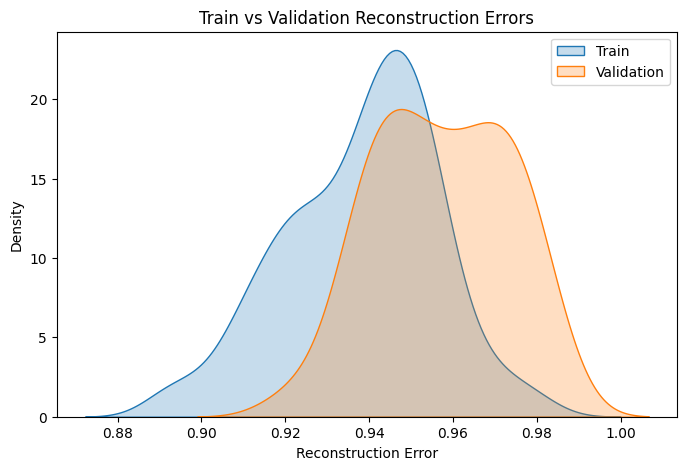

Median Train Err: 0.9408 | Median Val Err: 0.9580
Epoch 1/200 | Train Loss: 1.0196 | Val Loss: 1.0800
Epoch 1/200 | Train Loss: 1.0196 | Val Loss: 1.0800
Epoch 10/200 | Train Loss: 0.9972 | Val Loss: 1.0206
Epoch 10/200 | Train Loss: 0.9972 | Val Loss: 1.0206
Epoch 20/200 | Train Loss: 0.9795 | Val Loss: 0.9868
Epoch 20/200 | Train Loss: 0.9795 | Val Loss: 0.9868
Epoch 30/200 | Train Loss: 0.9023 | Val Loss: 0.9273
Epoch 30/200 | Train Loss: 0.9023 | Val Loss: 0.9273
Epoch 40/200 | Train Loss: 0.8740 | Val Loss: 0.8933
Epoch 50/200 | Train Loss: 0.8293 | Val Loss: 0.8772
Epoch 40/200 | Train Loss: 0.8740 | Val Loss: 0.8933
Epoch 50/200 | Train Loss: 0.8293 | Val Loss: 0.8772
Epoch 60/200 | Train Loss: 0.7968 | Val Loss: 0.8618
Epoch 70/200 | Train Loss: 0.7681 | Val Loss: 0.8478
Epoch 60/200 | Train Loss: 0.7968 | Val Loss: 0.8618
Epoch 70/200 | Train Loss: 0.7681 | Val Loss: 0.8478
Epoch 80/200 | Train Loss: 0.7439 | Val Loss: 0.8391
Epoch 90/200 | Train Loss: 0.7230 | Val Loss: 0.830

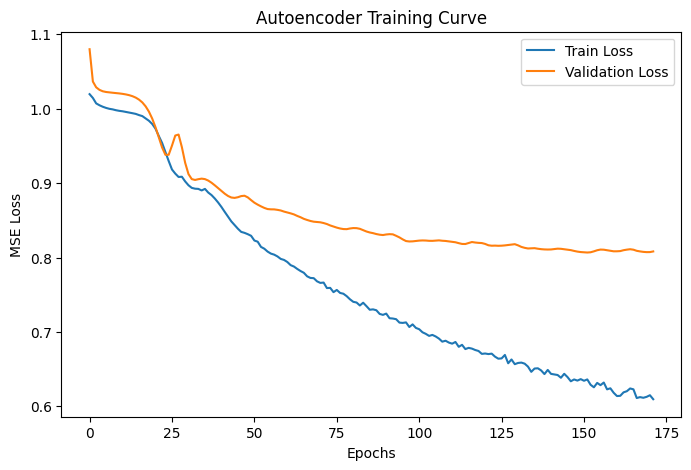

Epoch 1/200 | Train Loss: 1.0185 | Val Loss: 1.0731
Epoch 10/200 | Train Loss: 0.9969 | Val Loss: 1.0207
Epoch 20/200 | Train Loss: 0.9880 | Val Loss: 1.0060
Epoch 20/200 | Train Loss: 0.9880 | Val Loss: 1.0060
Epoch 30/200 | Train Loss: 0.9103 | Val Loss: 0.9539
Epoch 30/200 | Train Loss: 0.9103 | Val Loss: 0.9539
Epoch 40/200 | Train Loss: 0.8856 | Val Loss: 0.9025
Epoch 40/200 | Train Loss: 0.8856 | Val Loss: 0.9025
Epoch 50/200 | Train Loss: 0.8254 | Val Loss: 0.8712
Epoch 50/200 | Train Loss: 0.8254 | Val Loss: 0.8712
Epoch 60/200 | Train Loss: 0.7869 | Val Loss: 0.8549
Epoch 70/200 | Train Loss: 0.7603 | Val Loss: 0.8466
Epoch 60/200 | Train Loss: 0.7869 | Val Loss: 0.8549
Epoch 70/200 | Train Loss: 0.7603 | Val Loss: 0.8466
Epoch 80/200 | Train Loss: 0.7361 | Val Loss: 0.8353
Epoch 90/200 | Train Loss: 0.7154 | Val Loss: 0.8265
Epoch 80/200 | Train Loss: 0.7361 | Val Loss: 0.8353
Epoch 90/200 | Train Loss: 0.7154 | Val Loss: 0.8265
Epoch 100/200 | Train Loss: 0.6911 | Val Loss: 

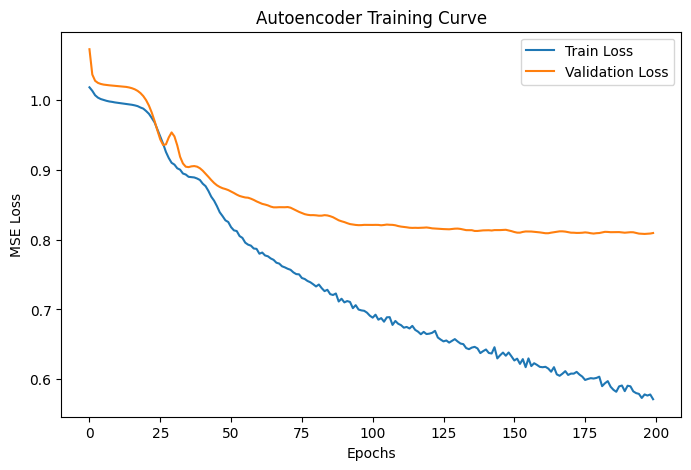

Latent stability (corr between runs): 0.004
Silhouette on fused latents: 0.12213847786188126
Silhouette on fused latents: 0.12213847786188126


In [ ]:
from sklearn.metrics import silhouette_score
import seaborn as sns

# ------------------ Diagnostics ------------------
def reconstruction_error_distribution(model, X_train_np, X_val_np, device):
    """Compute and plot per-sample reconstruction errors for train/val."""
    def recon_errors(X_np):
        model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X_np, dtype=torch.float32).to(device)
            _, recon = model(X_t)
        errs = ((recon.cpu().numpy() - X_np)**2).mean(axis=1)
        return errs

    errs_train = recon_errors(X_train_np)
    errs_val   = recon_errors(X_val_np)

    # KDE plots
    plt.figure(figsize=(8,5))
    sns.kdeplot(errs_train, label="Train", shade=True)
    sns.kdeplot(errs_val, label="Validation", shade=True)
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Density")
    plt.title("Train vs Validation Reconstruction Errors")
    plt.legend()
    plt.show()

    print(f"Median Train Err: {np.median(errs_train):.4f} | Median Val Err: {np.median(errs_val):.4f}")

    return errs_train, errs_val

def latent_stability_check(model_class, data, latent_dim, device, n_runs=2):
    """Train AE multiple times and check correlation between latent spaces."""
    latents = []
    for seed in range(n_runs):
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = model_class(data.shape[1], latent_dim=latent_dim).to(device)
        model = train_autoencoder(model, data, normalize=True)
        with torch.no_grad():
            z, _ = model(data.to(device))
        latents.append(z.cpu().numpy())

    # Compare pairwise correlations
    corr = np.corrcoef(latents[0].ravel(), latents[1].ravel())[0,1]
    print(f"Latent stability (corr between runs): {corr:.3f}")

    return corr

# ------------------ Example usage ------------------
# After training each AE, run diagnostics:
# (inside train_autoencoder, you already split train/val)

# 1. Check per-sample reconstruction errors
X_train_np, X_val_np = train_test_split(gene.cpu().numpy(), test_size=0.2, random_state=42)
errs_train, errs_val = reconstruction_error_distribution(ae_gene, X_train_np, X_val_np, device)

# 2. Latent stability
latent_stability_check(Autoencoder, gene, latent_dim=64, device=device)

# 3. (Optional) Quick clustering sanity check on fused latents
from sklearn.cluster import KMeans
z_np = z_fused.cpu().numpy()
kmeans = KMeans(n_clusters=3, random_state=42).fit(z_np)
score = silhouette_score(z_np, kmeans.labels_)
print("Silhouette on fused latents:", score)


In [ ]:
from sklearn.cluster import KMeans

# number of clusters: if unknown, try different values & compare
n_clusters = 3  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(z_fused.cpu().numpy())


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

X = z_fused.cpu().numpy()

sil_score = silhouette_score(X, cluster_labels)
ch_score  = calinski_harabasz_score(X, cluster_labels)
db_score  = davies_bouldin_score(X, cluster_labels)

print("Silhouette Score:", sil_score)              # higher is better ([-1, 1])
print("Calinski-Harabasz Score:", ch_score)        # higher is better
print("Davies-Bouldin Score:", db_score)           # lower is better



Silhouette Score: 0.12213847786188126
Calinski-Harabasz Score: 25.65924072265625
Davies-Bouldin Score: 2.4483028727913263


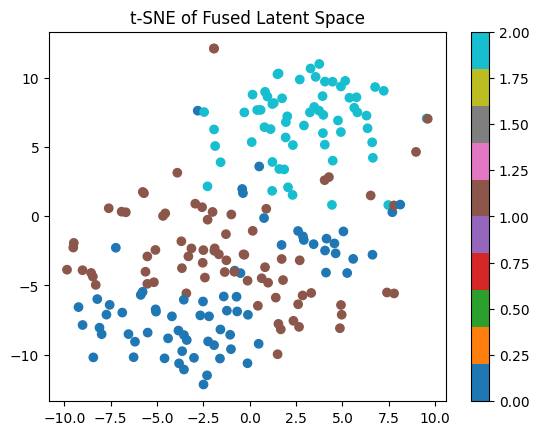

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z_fused.cpu().numpy())

plt.scatter(z_2d[:,0], z_2d[:,1], c=cluster_labels, cmap="tab10")
plt.colorbar()
plt.title("t-SNE of Fused Latent Space")
plt.show()


# Supervised Machine Learning Evaluation

Now let's train multiple classifiers on the fused features and evaluate with detailed metrics.

In [ ]:
# Load subtype labels
labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

# Align labels with our data
common_samples = gene_df.index.intersection(labels_df.index)
print(f"Samples with labels: {len(common_samples)}")

# Filter data and labels to common samples
labels = labels_df.loc[common_samples].values.ravel()
z_fused_labeled = z_fused.cpu().numpy()

# If data was already aligned, we might need to reindex
if len(common_samples) < len(gene_df):
    # Refilter if needed
    gene_idx = gene_df.index.get_indexer(common_samples)
    z_fused_labeled = z_fused.cpu().numpy()[gene_idx]

print(f"Final data shape: {z_fused_labeled.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique classes: {np.unique(labels)}")
print(f"Class distribution: {np.bincount(labels.astype(int))}")

Samples with labels: 205
Final data shape: (205, 192)
Labels shape: (205,)
Unique classes: [0 1 2 3]
Class distribution: [53 22 96 34]


Embeddings shape: (205, 192)
Labels shape: (205,)
Unique labels: [0 1 2 3]
Computing PCA...
Computing t-SNE...


C:\Users\shini\AppData\Local\Temp\ipykernel_2144\597130588.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 2].set_xticklabels(omic_contributions.keys(), rotation=45)


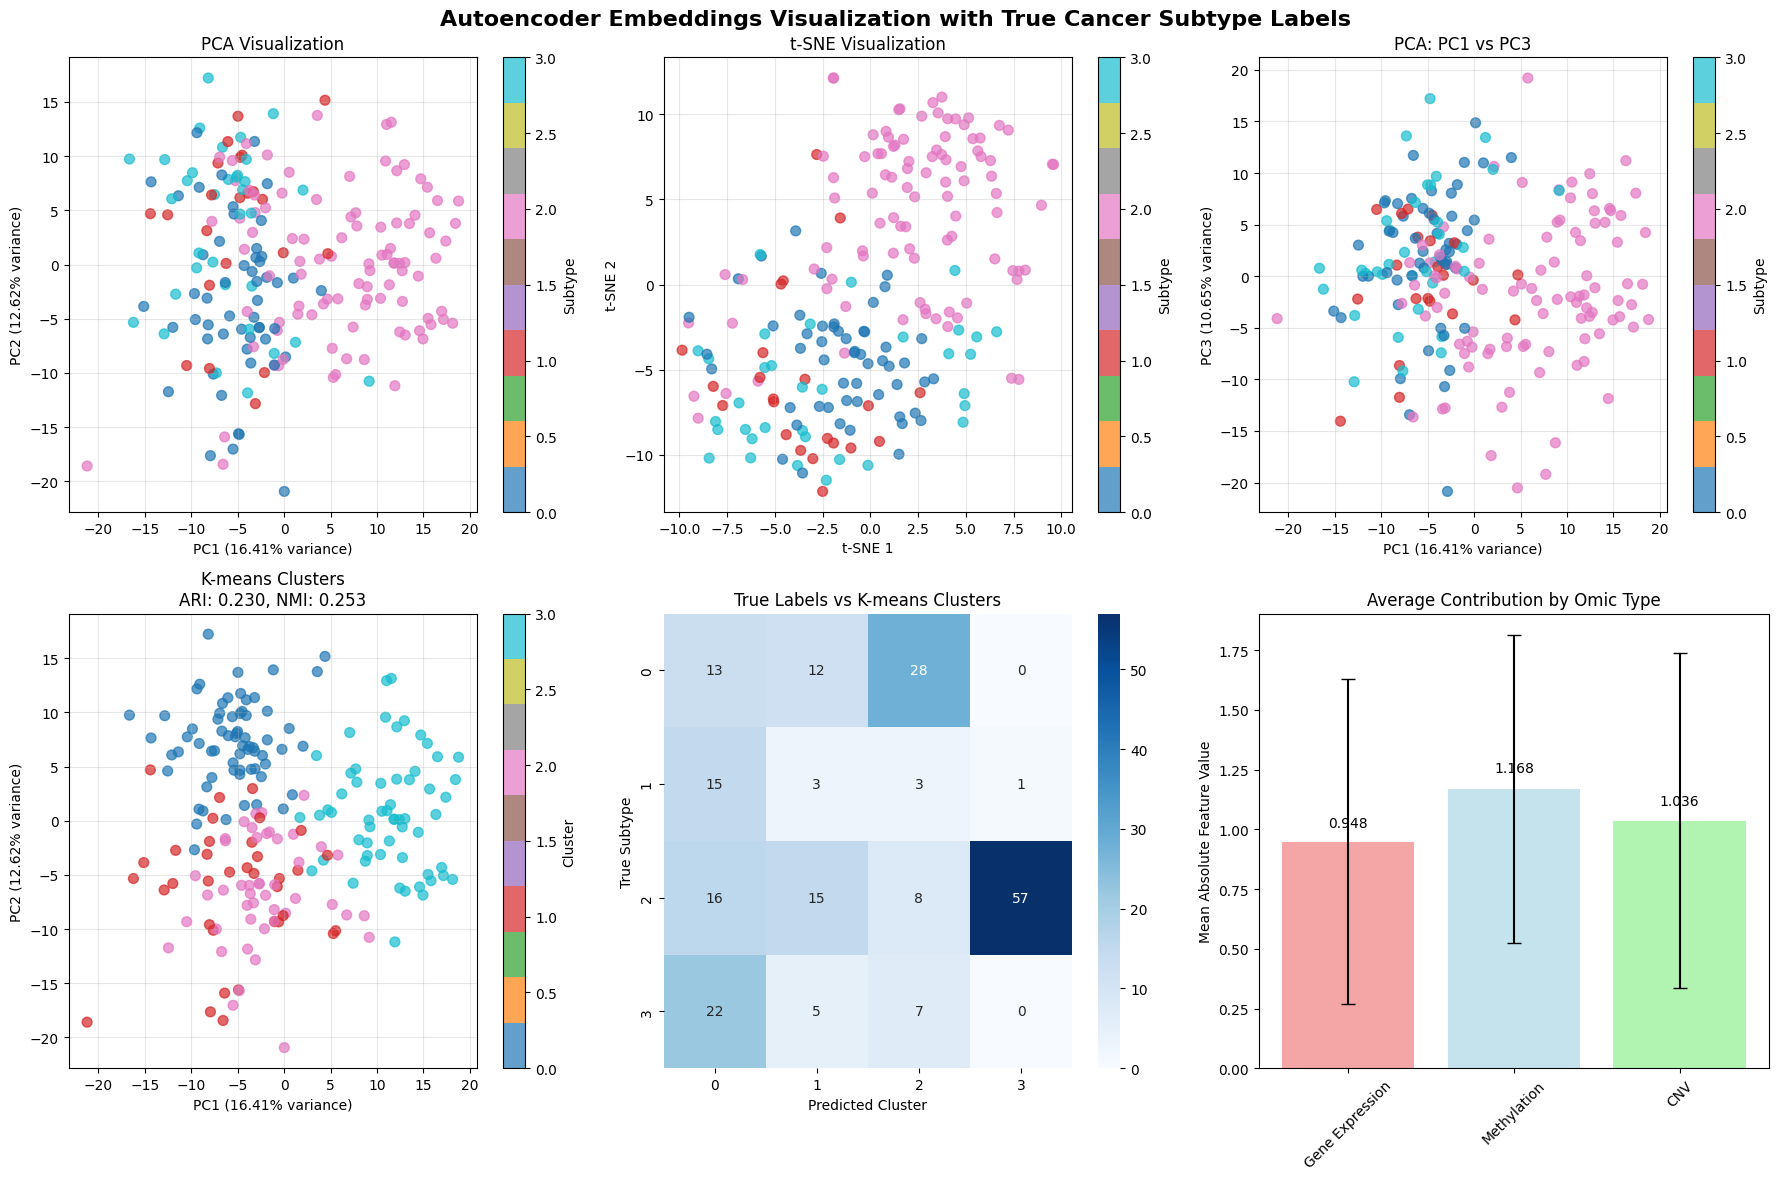

In [ ]:
# Visualize embeddings with actual labels
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Get the fused embeddings and labels
embeddings = z_fused_labeled
true_labels = labels

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {true_labels.shape}")
print(f"Unique labels: {np.unique(true_labels)}")

# Create label names (assuming 0,1,2,3 are different cancer subtypes)
label_names = {0: 'Subtype 0', 1: 'Subtype 1', 2: 'Subtype 2', 3: 'Subtype 3'}
colored_labels = [label_names.get(int(label), f'Subtype {int(label)}') for label in true_labels]

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Autoencoder Embeddings Visualization with True Cancer Subtype Labels', fontsize=16, fontweight='bold')

# 1. PCA 2D visualization
print("Computing PCA...")
pca_2d = PCA(n_components=2, random_state=42)
embeddings_pca_2d = pca_2d.fit_transform(embeddings)

scatter1 = axes[0, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[0, 0].set_title('PCA Visualization')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Subtype')

# 2. t-SNE 2D visualization
print("Computing t-SNE...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne_2d = tsne_2d.fit_transform(embeddings)

scatter2 = axes[0, 1].scatter(embeddings_tsne_2d[:, 0], embeddings_tsne_2d[:, 1], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')
axes[0, 1].set_title('t-SNE Visualization')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Subtype')

# 3. PCA 3D to 2D projections (PC1 vs PC3)
pca_3d = PCA(n_components=3, random_state=42)
embeddings_pca_3d = pca_3d.fit_transform(embeddings)

scatter3 = axes[0, 2].scatter(embeddings_pca_3d[:, 0], embeddings_pca_3d[:, 2], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 2].set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 2].set_ylabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)')
axes[0, 2].set_title('PCA: PC1 vs PC3')
axes[0, 2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[0, 2], label='Subtype')

# 4. Cluster analysis comparison
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Perform K-means clustering
n_clusters = len(np.unique(true_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(embeddings)

# Calculate clustering metrics
ari_score = adjusted_rand_score(true_labels, predicted_clusters)
nmi_score = normalized_mutual_info_score(true_labels, predicted_clusters)

scatter4 = axes[1, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                             c=predicted_clusters, cmap='tab10', alpha=0.7, s=50)
axes[1, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[1, 0].set_title(f'K-means Clusters\nARI: {ari_score:.3f}, NMI: {nmi_score:.3f}')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 0], label='Cluster')

# 5. Side-by-side comparison: True vs Predicted
# Create a subplot for confusion-like comparison
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_clusters)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted Cluster')
axes[1, 1].set_ylabel('True Subtype')
axes[1, 1].set_title('True Labels vs K-means Clusters')

# 6. Feature importance heatmap (top features from each omic)
# Show contribution of each omic type to the fused representation
omic_contributions = {
    'Gene Expression': embeddings[:, :64].mean(axis=0),  # First 64 features from gene AE
    'Methylation': embeddings[:, 64:128].mean(axis=0),   # Next 64 features from meth AE  
    'CNV': embeddings[:, 128:192].mean(axis=0)           # Last 64 features from cnv AE
}

omic_means = [np.mean(np.abs(contrib)) for contrib in omic_contributions.values()]
omic_stds = [np.std(np.abs(contrib)) for contrib in omic_contributions.values()]

bars = axes[1, 2].bar(omic_contributions.keys(), omic_means, 
                      yerr=omic_stds, capsize=5, alpha=0.7, 
                      color=['lightcoral', 'lightblue', 'lightgreen'])
axes[1, 2].set_ylabel('Mean Absolute Feature Value')
axes[1, 2].set_title('Average Contribution by Omic Type')
axes[1, 2].set_xticklabels(omic_contributions.keys(), rotation=45)

# Add value labels on bars
for bar, mean_val in zip(bars, omic_means):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.05,
                    f'{mean_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix, roc_auc_score)
import seaborn as sns

# C-index calculation function
def concordance_index(y_true, y_pred_proba):
    """
    Calculate C-index (Concordance Index) for multi-class classification.
    Uses macro-averaged AUC for multi-class problems.
    """
    try:
        # For multi-class, use macro-averaged AUC as C-index
        c_index = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
        return c_index
    except:
        return 0.0

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    z_fused_labeled, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training class distribution: {np.bincount(y_train.astype(int))}")
print(f"Test class distribution: {np.bincount(y_test.astype(int))}")

Training set size: 164
Test set size: 41
Training class distribution: [42 18 77 27]
Test class distribution: [11  4 19  7]


In [ ]:
# Define multiple classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42)
}

# Store results
results = []

print("Training and evaluating classifiers...\n")
print("="*80)

for name, clf in classifiers.items():
    # print(f"\n{name}:")
    # print("-"*80)
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    c_index = concordance_index(y_test, y_pred_proba)
    
    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'C-Index': c_index
    })
    
    # Print metrics
    # print(f"Accuracy:           {accuracy:.4f}")
    # print(f"Precision (Macro):  {precision_macro:.4f}")
    # print(f"Precision (Micro):  {precision_micro:.4f}")
    # print(f"Recall (Macro):     {recall_macro:.4f}")
    # print(f"Recall (Micro):     {recall_micro:.4f}")
    # print(f"F1-Score (Macro):   {f1_macro:.4f}")
    # print(f"F1-Score (Micro):   {f1_micro:.4f}")



Training and evaluating classifiers...



f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
# Native Autoencoder-based Classifiers
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class AEClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[128, 64], dropout=0.3):
        super(AEClassifier, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_ae_classifier(model, X_train, y_train, X_test, y_test, epochs=200, patience=15):
    """Train AE-based classifier with early stopping"""
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    best_test_acc = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Testing
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_acc = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        
        train_acc = train_correct / train_total
        scheduler.step(test_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        # Early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model

# Train different AE-based classifier architectures
num_classes = len(np.unique(labels))
input_dim = z_fused_labeled.shape[1]

print("Training Native Autoencoder-based Classifiers...")
print("-" * 50)

# Shallow AE Classifier
shallow_ae = AEClassifier(input_dim, num_classes, hidden_dims=[64], dropout=0.2).to(device)
print("Training Shallow AE Classifier...")
shallow_ae = train_ae_classifier(shallow_ae, X_train, y_train, X_test, y_test)

# Deep AE Classifier
deep_ae = AEClassifier(input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.3).to(device)
print("\nTraining Deep AE Classifier...")
deep_ae = train_ae_classifier(deep_ae, X_train, y_train, X_test, y_test)

def evaluate_ae_classifier(model, X_test, y_test, model_name):
    """Evaluate AE-based classifier and return metrics"""
    import torch.nn.functional as F
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        outputs = model(X_test_tensor)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        _, predicted = torch.max(outputs.data, 1)
        y_pred = predicted.cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    c_index = roc_auc_score(y_test, probs, multi_class='ovr', average='macro')
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'C-Index': c_index
    }

# Evaluate all AE-based models
ae_results = []
ae_results.append(evaluate_ae_classifier(shallow_ae, X_test, y_test, "Shallow AE"))
ae_results.append(evaluate_ae_classifier(deep_ae, X_test, y_test, "Deep AE"))

print("\n" + "="*80)
print("NATIVE AUTOENCODER-BASED CLASSIFICATION RESULTS")
print("="*80)
ae_results_df = pd.DataFrame(ae_results)
print(ae_results_df.to_string(index=False))


Training Native Autoencoder-based Classifiers...
--------------------------------------------------
Training Shallow AE Classifier...
Early stopping at epoch 35

Training Deep AE Classifier...
Early stopping at epoch 35

Training Deep AE Classifier...
Early stopping at epoch 34

NATIVE AUTOENCODER-BASED CLASSIFICATION RESULTS
     Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)
Shallow AE  0.731707           0.526136           0.731707        0.584074        0.731707    0.547314    0.731707
   Deep AE  0.731707           0.618129           0.731707        0.610860        0.731707    0.610589    0.731707
Early stopping at epoch 34

NATIVE AUTOENCODER-BASED CLASSIFICATION RESULTS
     Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)
Shallow AE  0.731707           0.526136           0.731707        0.584074        0.731707    0.547314    0.731707
   Deep AE  0.731707 

In [ ]:
# Combine Traditional ML and Native AE Results
print("\n" + "="*80)
print("COMBINED RESULTS: TRADITIONAL ML vs NATIVE AUTOENCODER-BASED CLASSIFIERS")
print("="*80)

# Combine all results
all_results = results + ae_results
combined_df = pd.DataFrame(all_results)
combined_df = combined_df.sort_values('Accuracy', ascending=False)

print(combined_df.to_string(index=False))



COMBINED RESULTS: TRADITIONAL ML vs NATIVE AUTOENCODER-BASED CLASSIFIERS
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
  Gradient Boosting  0.780488           0.697403           0.780488        0.646745        0.780488    0.659988    0.780488 0.877221
        Naive Bayes  0.780488           0.693750           0.780488        0.718643        0.780488    0.702001    0.780488 0.885061
      Random Forest  0.756098           0.784722           0.756098        0.656143        0.756098    0.658927    0.756098 0.920390
K-Nearest Neighbors  0.756098           0.611842           0.756098        0.664602        0.756098    0.627949    0.756098 0.893982
Logistic Regression  0.731707           0.538889           0.731707        0.606630        0.731707    0.566600    0.731707 0.886610
          SVM (RBF)  0.731707           0.507872           0.731707        0.571087        0.731707    0.536184    0.731707 0.89

In [ ]:
# Enhanced Results Table with C-Index Highlighted
print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON WITH C-INDEX SCORES")
print("="*100)

# Sort by C-Index for additional perspective
combined_df_c_index = combined_df.sort_values('C-Index', ascending=False)

print("\n🏆 RANKING BY C-INDEX (Discriminative Ability):")
print("-"*100)
print(combined_df_c_index[['Model', 'Accuracy', 'F1 (Macro)', 'C-Index']].to_string(index=False))

print("\n📊 DETAILED METRICS TABLE:")
print("-"*100)
print(combined_df.to_string(index=False))



COMPREHENSIVE MODEL COMPARISON WITH C-INDEX SCORES

🏆 RANKING BY C-INDEX (Discriminative Ability):
----------------------------------------------------------------------------------------------------
              Model  Accuracy  F1 (Macro)  C-Index
      Random Forest  0.756098    0.658927 0.920390
          SVM (RBF)  0.731707    0.536184 0.895896
K-Nearest Neighbors  0.756098    0.627949 0.893982
Logistic Regression  0.731707    0.566600 0.886610
        Naive Bayes  0.780488    0.702001 0.885061
  Gradient Boosting  0.780488    0.659988 0.877221
       SVM (Linear)  0.682927    0.523463 0.874315
      Decision Tree  0.682927    0.591820 0.761271
            Deep AE  0.731707    0.610589      NaN
         Shallow AE  0.731707    0.547314      NaN

📊 DETAILED METRICS TABLE:
----------------------------------------------------------------------------------------------------
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro

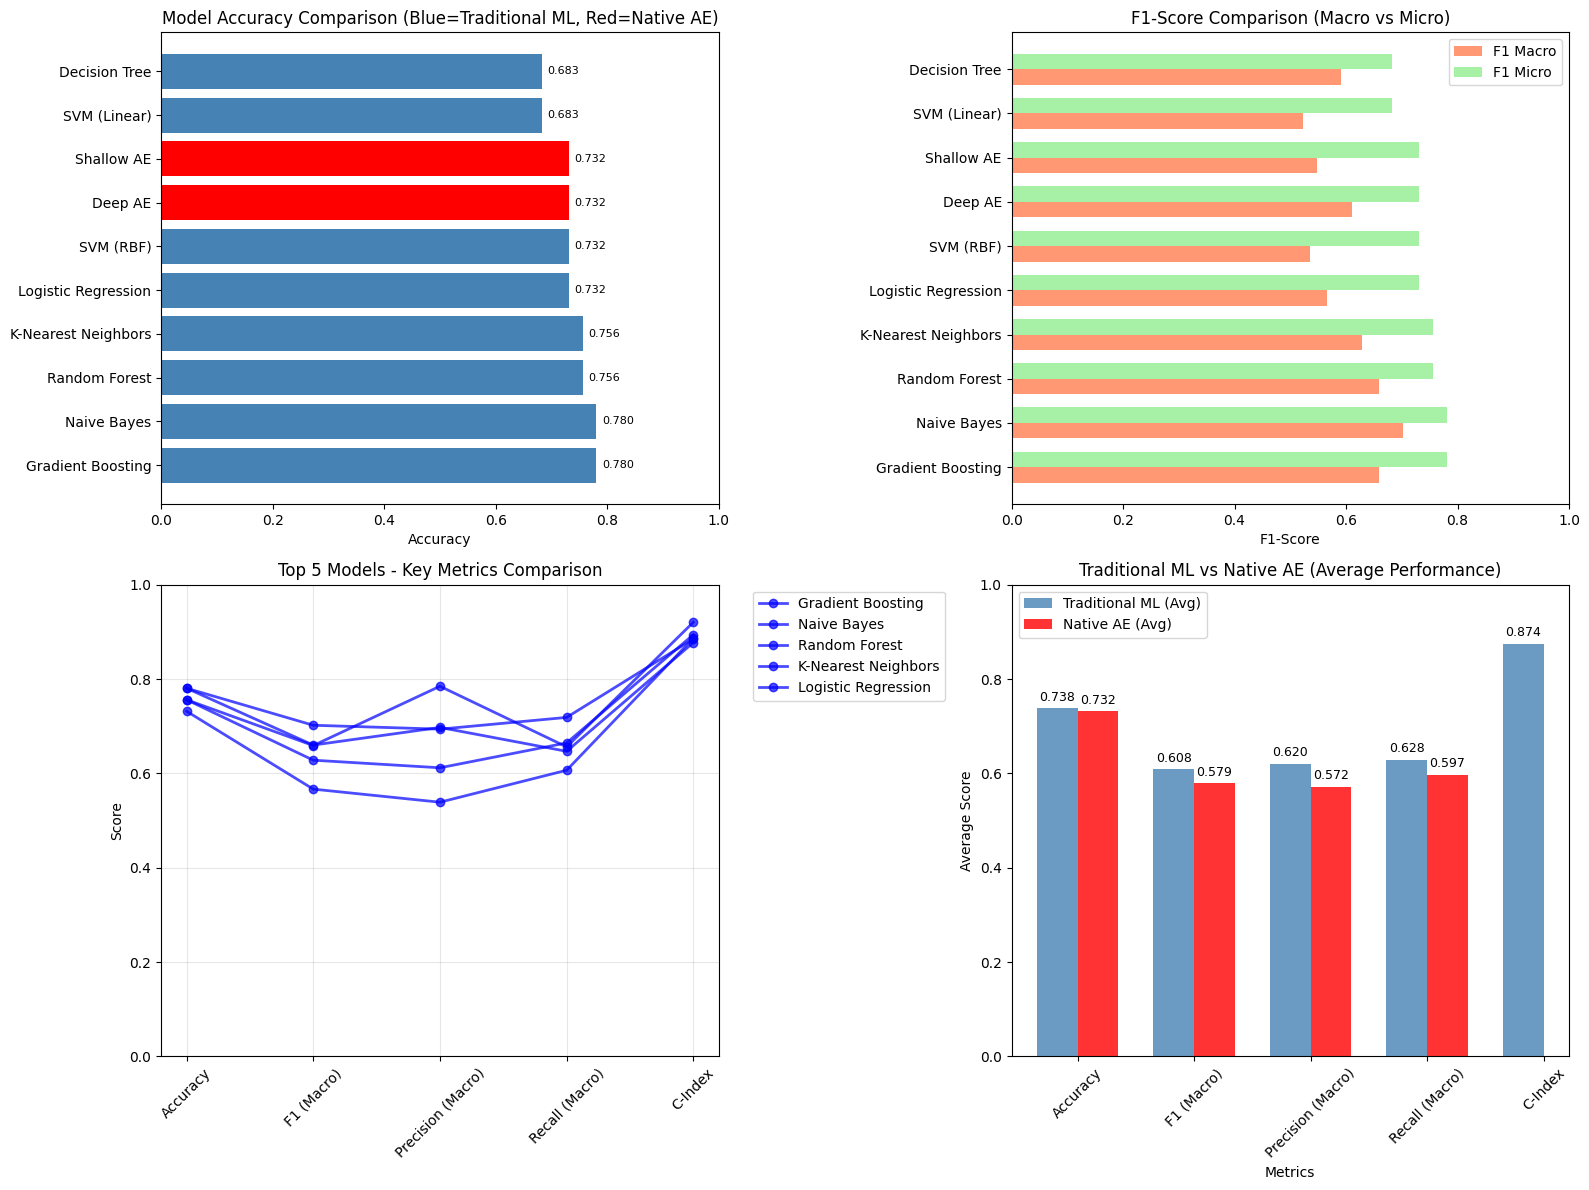

In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Separate traditional ML and AE results for color coding (ensure C-Index column exists)
traditional_ml = combined_df[~combined_df['Model'].str.contains('AE')].copy()
native_ae = combined_df[combined_df['Model'].str.contains('AE')].copy()

# Plot 1: Accuracy comparison with color coding
colors = ['steelblue' if 'AE' not in model else 'red' for model in combined_df['Model']]
bars1 = axes[0, 0].barh(combined_df['Model'], combined_df['Accuracy'], color=colors)
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison (Blue=Traditional ML, Red=Native AE)')
axes[0, 0].set_xlim([0, 1])

# Add accuracy values on bars
for i, (bar, acc) in enumerate(zip(bars1, combined_df['Accuracy'])):
    axes[0, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{acc:.3f}', va='center', fontsize=8)

# Plot 2: F1-Score comparison (Macro and Micro)
x = np.arange(len(combined_df))
width = 0.35
bars2 = axes[0, 1].barh(x - width/2, combined_df['F1 (Macro)'], width, 
                        label='F1 Macro', color='coral', alpha=0.8)
bars3 = axes[0, 1].barh(x + width/2, combined_df['F1 (Micro)'], width, 
                        label='F1 Micro', color='lightgreen', alpha=0.8)
axes[0, 1].set_yticks(x)
axes[0, 1].set_yticklabels(combined_df['Model'])
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('F1-Score Comparison (Macro vs Micro)')
axes[0, 1].legend()
axes[0, 1].set_xlim([0, 1])

# Plot 3: Top 5 models performance radar chart style
top_5 = combined_df.head(5)
metrics = ['Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)']
if 'C-Index' in combined_df.columns:
    metrics.append('C-Index')
x_pos = np.arange(len(metrics))

for i, (_, row) in enumerate(top_5.iterrows()):
    values = [row[metric] for metric in metrics]
    color = 'red' if 'AE' in row['Model'] else 'blue'
    axes[1, 0].plot(x_pos, values, 'o-', label=row['Model'], 
                    linewidth=2, markersize=6, alpha=0.7, color=color)

axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(metrics, rotation=45)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Top 5 Models - Key Metrics Comparison')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Model type performance summary
# Ensure C-Index column exists before calculating averages
available_metrics = ['Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)']
if 'C-Index' in combined_df.columns:
    available_metrics.append('C-Index')

traditional_avg = traditional_ml[available_metrics].mean()
ae_avg = native_ae[available_metrics].mean()

categories = available_metrics
x_pos = np.arange(len(categories))
width = 0.35

bars4 = axes[1, 1].bar(x_pos - width/2, traditional_avg, width, 
                       label='Traditional ML (Avg)', color='steelblue', alpha=0.8)
bars5 = axes[1, 1].bar(x_pos + width/2, ae_avg, width, 
                       label='Native AE (Avg)', color='red', alpha=0.8)

axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Average Score')
axes[1, 1].set_title('Traditional ML vs Native AE (Average Performance)')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(categories, rotation=45)
axes[1, 1].legend()
axes[1, 1].set_ylim([0, 1])

# Add value labels on bars
for bars in [bars4, bars5]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*80)

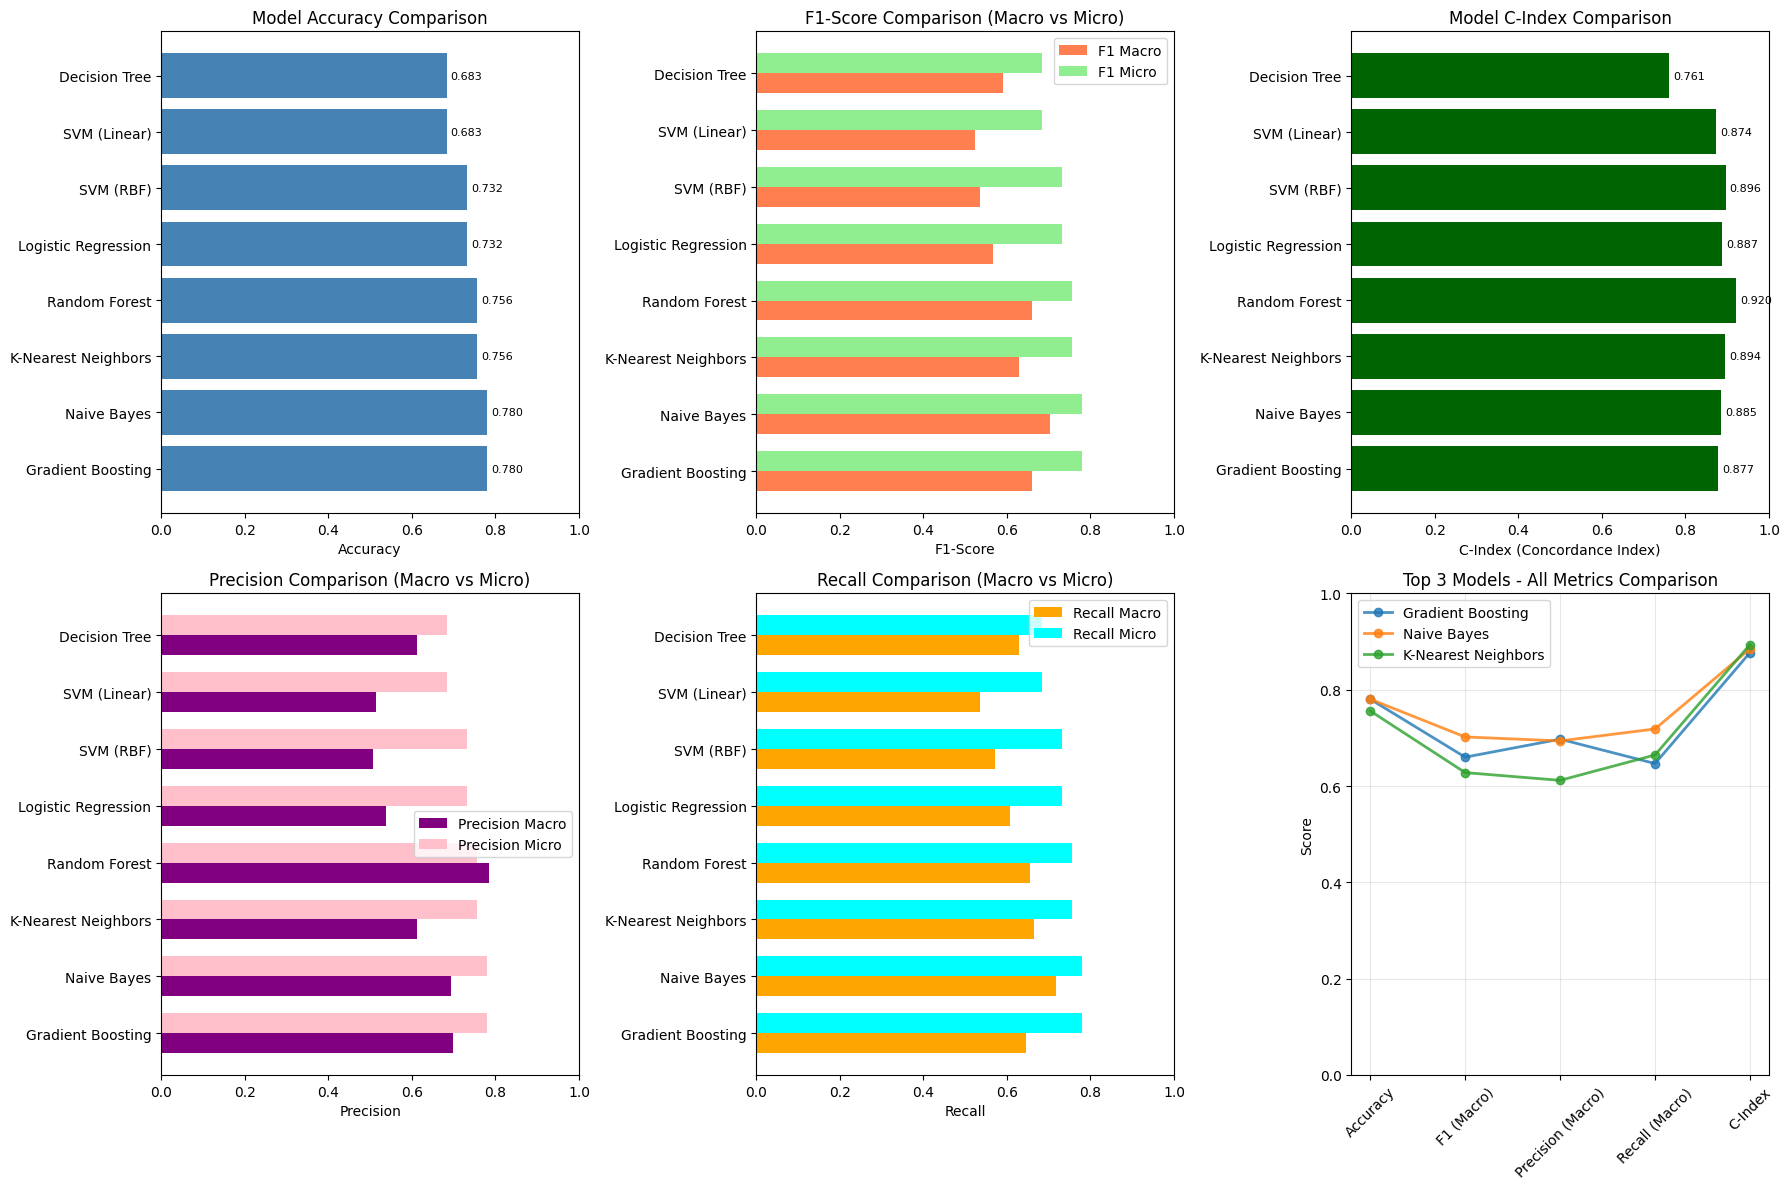

In [ ]:
# Create a summary dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Accuracy comparison
bars1 = axes[0, 0].barh(results_df['Model'], results_df['Accuracy'], color='steelblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlim([0, 1])
# Add accuracy values on bars
for bar, acc in zip(bars1, results_df['Accuracy']):
    axes[0, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, f'{acc:.3f}', va='center', fontsize=8)

# Plot 2: F1-Score comparison (Macro and Micro)
x = np.arange(len(results_df))
width = 0.35
axes[0, 1].barh(x - width/2, results_df['F1 (Macro)'], width, label='F1 Macro', color='coral')
axes[0, 1].barh(x + width/2, results_df['F1 (Micro)'], width, label='F1 Micro', color='lightgreen')
axes[0, 1].set_yticks(x)
axes[0, 1].set_yticklabels(results_df['Model'])
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('F1-Score Comparison (Macro vs Micro)')
axes[0, 1].legend()
axes[0, 1].set_xlim([0, 1])

# Plot 3: C-Index comparison
bars3 = axes[0, 2].barh(results_df['Model'], results_df['C-Index'], color='darkgreen')
axes[0, 2].set_xlabel('C-Index (Concordance Index)')
axes[0, 2].set_title('Model C-Index Comparison')
axes[0, 2].set_xlim([0, 1])
# Add C-index values on bars
for bar, c_idx in zip(bars3, results_df['C-Index']):
    axes[0, 2].text(c_idx + 0.01, bar.get_y() + bar.get_height()/2, f'{c_idx:.3f}', va='center', fontsize=8)

# Plot 4: Precision comparison
axes[1, 0].barh(x - width/2, results_df['Precision (Macro)'], width, label='Precision Macro', color='purple')
axes[1, 0].barh(x + width/2, results_df['Precision (Micro)'], width, label='Precision Micro', color='pink')
axes[1, 0].set_yticks(x)
axes[1, 0].set_yticklabels(results_df['Model'])
axes[1, 0].set_xlabel('Precision')
axes[1, 0].set_title('Precision Comparison (Macro vs Micro)')
axes[1, 0].legend()
axes[1, 0].set_xlim([0, 1])

# Plot 5: Recall comparison
axes[1, 1].barh(x - width/2, results_df['Recall (Macro)'], width, label='Recall Macro', color='orange')
axes[1, 1].barh(x + width/2, results_df['Recall (Micro)'], width, label='Recall Micro', color='cyan')
axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels(results_df['Model'])
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_title('Recall Comparison (Macro vs Micro)')
axes[1, 1].legend()
axes[1, 1].set_xlim([0, 1])

# Plot 6: Combined metrics radar chart for top 3 models
top_3 = results_df.head(3)
metrics_radar = ['Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)', 'C-Index']
x_pos = np.arange(len(metrics_radar))

for i, (_, row) in enumerate(top_3.iterrows()):
    values = [row[metric] for metric in metrics_radar]
    axes[1, 2].plot(x_pos, values, 'o-', label=row['Model'], linewidth=2, markersize=6, alpha=0.8)

axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(metrics_radar, rotation=45)
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Top 3 Models - All Metrics Comparison')
axes[1, 2].legend()
axes[1, 2].set_ylim([0, 1])
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


DETAILED REPORT FOR BEST MODEL: Gradient Boosting

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9000    0.8182    0.8571        11
           1     0.5000    0.2500    0.3333         4
           2     0.8182    0.9474    0.8780        19
           3     0.5714    0.5714    0.5714         7

    accuracy                         0.7805        41
   macro avg     0.6974    0.6467    0.6600        41
weighted avg     0.7670    0.7805    0.7669        41



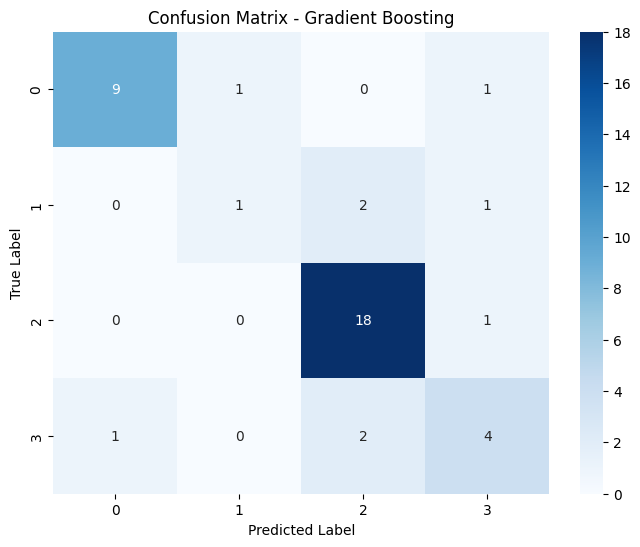


Confusion Matrix:
[[ 9  1  0  1]
 [ 0  1  2  1]
 [ 0  0 18  1]
 [ 1  0  2  4]]


In [ ]:
# Detailed classification report for the best model
best_model_name = results_df.iloc[0]['Model']
best_clf = classifiers[best_model_name]

print(f"\n{'='*80}")
print(f"DETAILED REPORT FOR BEST MODEL: {best_model_name}")
print(f"{'='*80}\n")

# Retrain on the data (already trained, but for clarity)
y_pred_best = best_clf.predict(X_test)

# Classification report
print("Classification Report (per-class metrics):")
print("-"*80)
print(classification_report(y_test, y_pred_best, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

print(f"\nConfusion Matrix:")
print(cm)

In [ ]:
# Cross-validation for the top 3 models
print(f"\n{'='*80}")
print("CROSS-VALIDATION RESULTS (5-Fold Stratified)")
print(f"{'='*80}\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (name, clf) in enumerate(list(classifiers.items())[:3]):  # Top 3 models
    scores = cross_val_score(clf, z_fused_labeled, labels, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(clf, z_fused_labeled, labels, cv=cv, scoring='f1_macro')
    roc_scores = cross_val_score(clf, z_fused_labeled, labels, cv=cv, scoring='roc_auc_ovr')
    
    print(f"{name}:")
    print(f"  Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"  F1-Macro: {f1_scores.mean():.4f} (+/- {f1_scores.std():.4f})")
    print(f"  C-Index:  {roc_scores.mean():.4f} (+/- {roc_scores.std():.4f})")
    print()


CROSS-VALIDATION RESULTS (5-Fold Stratified)

Random Forest:
  Accuracy: 0.7561 (+/- 0.0309)
  F1-Macro: 0.6518 (+/- 0.0463)
  C-Index:  0.9109 (+/- 0.0298)

Random Forest:
  Accuracy: 0.7561 (+/- 0.0309)
  F1-Macro: 0.6518 (+/- 0.0463)
  C-Index:  0.9109 (+/- 0.0298)

Gradient Boosting:
  Accuracy: 0.6634 (+/- 0.0993)
  F1-Macro: 0.5766 (+/- 0.1072)
  C-Index:  0.8246 (+/- 0.0366)

SVM (RBF):
  Accuracy: 0.7366 (+/- 0.0521)
  F1-Macro: 0.5415 (+/- 0.0440)
  C-Index:  0.8697 (+/- 0.0456)

Gradient Boosting:
  Accuracy: 0.6634 (+/- 0.0993)
  F1-Macro: 0.5766 (+/- 0.1072)
  C-Index:  0.8246 (+/- 0.0366)

SVM (RBF):
  Accuracy: 0.7366 (+/- 0.0521)
  F1-Macro: 0.5415 (+/- 0.0440)
  C-Index:  0.8697 (+/- 0.0456)

